In [1]:
from torch import nn

import torch
from abc import abstractmethod
import torch.tensor as Tensor
import seaborn as sn
import matplotlib.pyplot as plt


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [35]:
def KL(theta0, theta1, k=1, device='cpu', p=2):
    """
        Parameters:
            theta0 (Tensor): Samples, P X NbDimensions
            theta1 (Tensor): Samples, R X NbDimensions
            k (Int): positive ordinal number

        Returns:
            (Float) k-Nearest Neighbour Estimation of the KL from theta0 to theta1

        Kullback-Leibler Divergence Estimation of Continuous Distributions Fernando Pérez-Cruz
        """

    n0 = theta0.shape[0]
    n1 = theta1.shape[0]
    dim0 = theta0.shape[1]
    dim1 = theta1.shape[1]
    assert dim0 == dim1

    D0 = torch.cdist(theta0, theta0, p=p)
    D1 = torch.cdist(theta0, theta1, p=p)

    a0 = torch.topk(D0, k=k + 1, dim=1, largest=False, sorted=True)[0][:,k]  # .clamp(torch.finfo().eps,float('inf')).to(device)
    a1 = torch.topk(D1, k=k, dim=1, largest=False, sorted=True)[0][:,k - 1]  # .clamp(torch.finfo().eps,float('inf')).to(device)

    assert a0.shape == a1.shape, 'dimension do not match'

    d = torch.as_tensor(float(dim0), device=device)
    N0 = torch.as_tensor(float(n0), device=device)
    N1 = torch.as_tensor(float(n1), device=device)

    Mnn = (torch.log(a1) - 0.5*torch.log(a0)).mean()
    return d * Mnn + N1.log() - (N0 - 1).log()

In [111]:
# from https://github.com/AntixK/Spectral-Stein-Gradient
# modified
class BaseScoreEstimator:

    @staticmethod
    def rbf_kernel(x1: Tensor,
                   x2: Tensor,
                   sigma: float) -> Tensor:
        return torch.exp(-((x1 - x2).pow(2).sum(-1))/(2 * sigma ** 2))

    def gram_matrix(self,
             x1: Tensor,
             x2: Tensor,
             sigma: float) -> Tensor:
        x1 = x1.unsqueeze(-2) # Make it into a column tensor
        x2 = x2.unsqueeze(-3) # Make it into a row tensor
        return self.rbf_kernel(x1, x2, sigma)

    def grad_gram(self,
                  x1: Tensor,
                  x2: Tensor,
                  sigma: float) -> Tensor:
        """
        Computes the gradients of the RBF gram matrix with respect
        to the inputs x1 an x2. It is given by
        .. math::
            \nabla_x1 k(x1, x2) = k(x1, x2) \frac{x1- x2}{\sigma^2}
            \nabla_x2 k(x1, x2) = k(x1, x2) -\frac{x1- x2}{\sigma^2}
        :param x1: (Tensor) [N x D]
        :param x2: (Tensor) [M x D]
        :param sigma: (Float) Width of the RBF kernel
        :return: Gram matrix [N x M],
                 gradients with respect to x1 [N x M x D],
                 gradients with respect to x2 [N x M x D]
        """
        with torch.no_grad():
            Kxx = self.gram_matrix(x1, x2, sigma)

            x1 = x1.unsqueeze(-2)  # Make it into a column tensor
            x2 = x2.unsqueeze(-3)  # Make it into a row tensor
            diff = (x1 - x2) / (sigma ** 2)

            dKxx_dx1 = Kxx.unsqueeze(-1) * (-diff)
            dKxx_dx2 = Kxx.unsqueeze(-1) * diff
            return Kxx, dKxx_dx1, dKxx_dx2

    def heuristic_sigma(self,
                        x:Tensor,
                        xm: Tensor) -> Tensor:
        """
        Uses the median-heuristic for selecting the
        appropriate sigma for the RBF kernel based
        on the given samples.
        The kernel width is set to the media of the
        pairwise distances between x and xm.
        :param x: (Tensor) [N x D]
        :param xm: (Tensor) [M x D]
        :return:
        """

        with torch.no_grad():
            x1 = x.unsqueeze(-2)   # Make it into a column tensor
            x2 = xm.unsqueeze(-3)  # Make it into a row tensor

            pdist_mat = torch.sqrt(((x1 - x2) ** 2).sum(dim = -1)) # [N x M]
            kernel_width = torch.median(torch.flatten(pdist_mat))
            return kernel_width

    @abstractmethod
    def compute_score_gradients(self, x: Tensor, xm: Tensor = None):
        raise NotImplementedError

    def __call__(self, x: Tensor, xm: Tensor = None):
        return self.compute_score_gradients(x, xm)

In [112]:
class SpectralSteinEstimator(BaseScoreEstimator):
    def __init__(self,
                 eta: float = None,
                 num_eigs: int = None) -> None:
        self.eta = eta
        self.num_eigs = num_eigs

    def nystrom_method(self,
                       x: Tensor,
                       eval_points: Tensor,
                       eigen_vecs: Tensor,
                       eigen_vals: Tensor,
                       kernel_sigma: float) -> Tensor:
        """
        Implements the Nystrom method for approximating the
        eigenfunction (generalized eigenvectors) for the kernel
        at x using the M eval_points (x_m). It is given
        by -
         .. math::
            phi_j(x) = \frac{M}{\lambda_j} \sum_{m=1}^M u_{jm} k(x, x_m)
        :param x: (Tensor) Point at which the eigenfunction is evaluated [N x D]
        :param eval_points: (Tensor) Sample points from the data of ize M [M x D]
        :param eigen_vecs: (Tensor) Eigenvectors of the gram matrix [M x M]
        :param eigen_vals: (Tensor) Eigenvalues of the gram matrix [M x 2]
        :param kernel_sigma: (Float) Kernel width
        :return: Eigenfunction at x [N x M]
        """
        M = torch.tensor(eval_points.size(-2), dtype=torch.float)
        Kxxm = self.gram_matrix(x, eval_points, kernel_sigma)
        phi_x =  torch.sqrt(M) * Kxxm @ eigen_vecs

        phi_x *= 1. / eigen_vals[:,0] # Take only the real part of the eigenvals
                                      # as the Im is 0 (Symmetric matrix)
        return phi_x


    def compute_score_gradients(self,
                                x: Tensor,
                                xm: Tensor = None) -> Tensor:
        """
        Computes the Spectral Stein Gradient Estimate (SSGE) for the
        score function. The SSGE is given by
        .. math::
            \nabla_{xi} phi_j(x) = \frac{1}{\mu_j M} \sum_{m=1}^M \nabla_{xi}k(x,x^m) \phi_j(x^m)
            \beta_{ij} = -\frac{1}{M} \sum_{m=1}^M \nabla_{xi} phi_j (x^m)
            \g_i(x) = \sum_{j=1}^J \beta_{ij} \phi_j(x)
        :param x: (Tensor) Point at which the gradient is evaluated [N x D]
        :param xm: (Tensor) Samples for the kernel [M x D]
        :return: gradient estimate [N x D]
        """
        if xm is None:
            xm = x
            sigma = self.heuristic_sigma(xm, xm)
        else:
            # Account for the new data points too
            _xm = torch.cat((x, xm), dim=-2)
            sigma = self.heuristic_sigma(_xm, _xm)

        M = torch.tensor(xm.size(-2), dtype=torch.float)

        Kxx, dKxx_dx, _ = self.grad_gram(xm, xm, sigma)

        # Kxx = Kxx + eta * I
        if self.eta is not None:
            Kxx += self.eta * torch.eye(xm.size(-2)).to(xm.device)

        eigen_vals, eigen_vecs = torch.eig(Kxx, eigenvectors=True)

        if self.num_eigs is not None:
            eigen_vals = eigen_vals[:self.num_eigs]
            eigen_vecs = eigen_vecs[:, :self.num_eigs]

        phi_x = self.nystrom_method(x, xm, eigen_vecs, eigen_vals, sigma) # [N x M]

        # Compute the Monte Carlo estimate of the gradient of
        # the eigenfunction at x
        dKxx_dx_avg = dKxx_dx.mean(dim=-3) #[M x D]

        beta = - torch.sqrt(M) * eigen_vecs.t() @ dKxx_dx_avg
        beta *= (1. / eigen_vals[:, 0].unsqueeze(-1))

        # assert beta.allclose(beta1), f"incorrect computation {beta - beta1}"
        g = phi_x @ beta # [N x D]
        return g

In [113]:
class EntropyGradient:

    def __init__(self,
                 eta: float,
                 num_eigs: int = None) -> None:

        self.score_estimator = SpectralSteinEstimator(eta = eta,
                                                      num_eigs=num_eigs)

    def compute_gradients(self,
                          x: Tensor,
                          x_grad: Tensor,
                          samples: Tensor = None,
                          return_score = False) -> Tensor:

        """
        Computes the gradient of the entropy with respect to the
        model that produced the samples x that mimics the samples
        from some modelling distribution q, from a prior
        distribution p(z). The gradient of the entropy is given by
        .. math::
            x = g_\theta(z), z \sim p(z)
            \nabla_\theta H(q) = - \nabla E_z [\nabla_x \log q(x) \nabla_theta g_\theta(z)]
        :param x: (Tensor) Data samples from the q distribution
                  or a one that mimics its samples. [N x D]
        :param x_grad: (Tensor) Gradient of those samples with
                       respect to its transformation parameters
        :param samples: (Tensor) Samples from the distribution q
                        This is optional. [N x D]
        :return: (Tensor) Gradient of the entropy
        """
        N  = x.size(0)

        # Flatten the vectors
        x = x.view(N, -1) # [N x CHW]
        x_grad = x_grad.view(N, -1) #[N x CHW]

        with torch.no_grad():
            score = self.score_estimator(x, samples) #[N x CHW]

        grad_entropy = -(score * x_grad).mean(dim=0) # Element-wise multiplication

        if return_score:
            return [grad_entropy, score]
        else:
            return grad_entropy

    def __call__(self,
                 x: Tensor,
                 x_grad: Tensor,
                 samples: Tensor = None,
                 return_score = False):

        return self.compute_gradients(x, x_grad, samples, return_score)

# test log density gaussian #

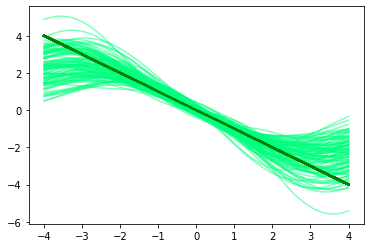

In [114]:
target = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.]))


points=torch.linspace(-4.,4.,400).unsqueeze(-1)


for _ in range(100):
    sample=target.sample((100,))
    score_estimator = SpectralSteinEstimator(eta=0.1)
    score = score_estimator(points,sample)

    plt.plot(points.squeeze(),score.squeeze(), alpha=0.5, color='springgreen')

    plt.plot(points.squeeze(),-points, color='green', linewidth=2.)


# SSGE #

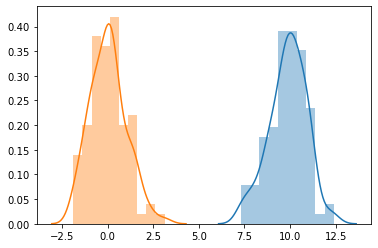

In [115]:
n_samples=100

target = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.]))


p=torch.tensor([1.]).detach().requires_grad_(True)
q=torch.tensor([10.]).detach().requires_grad_(True)
x=torch.randn(n_samples)

sn.distplot((p*x+q).detach())
sn.distplot(target.sample((100,)))


In [116]:
H_grad=[]
lr=0.1
KLs=[]
ps=[]
qs=[]
for _ in range(2000):
    x=torch.randn(n_samples)

    n_samples=x.shape[0]
    sample=(p*x+q).unsqueeze(-1)
    
    
    lp=-target.log_prob(sample).mean()
    lp_grad_p=torch.autograd.grad(lp,p,retain_graph=True)[0]
    lp_grad_q=torch.autograd.grad(lp,q,retain_graph=True)[0]
    
    
  
    # Get the estimate of the score 
    score_estimator = SpectralSteinEstimator(eta=0.1)

    score = score_estimator(sample,sample)
    
    p_grad = torch.autograd.grad(sample, p,
                          grad_outputs=score,
                          retain_graph=True)[0]/n_samples
    q_grad = torch.autograd.grad(sample, q,
                          grad_outputs=score,
                          retain_graph=True)[0]/n_samples
    entropy_grad=torch.cat([p_grad,q_grad],dim=0)
    KLs.append(KL(sample.view(-1,1),target.sample((n_samples,)),k=6,device='cpu').item())
    
   # print(lp_grad_p[0])
    
    H_grad.append(entropy_grad)
    p.data.add_(-lr*(entropy_grad[0]+lp_grad_p))
    q.data.add_(-lr*(entropy_grad[1]+lp_grad_q))
    ps.append(p.item())
    qs.append(q.item())

In [117]:
print(p.item(),q.item())

0.9582406878471375 -0.0006643948145210743


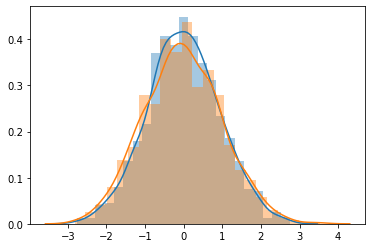

In [118]:
x=torch.randn(1000)
sn.distplot((p*x+q).detach())
sn.distplot(target.sample((1000,)))

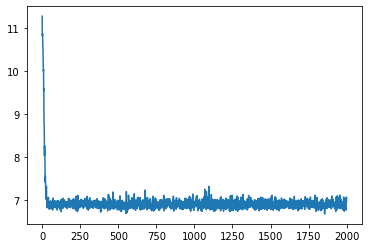

In [119]:
plt.plot(KLs)

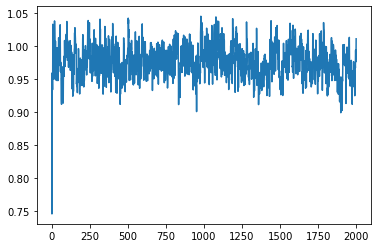

In [120]:
H_grad_=torch.stack(H_grad)

plt.plot(torch.arange(0,H_grad_.shape[0],1),H_grad_.norm(dim=1))

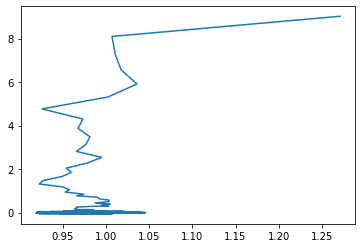

In [121]:
plt.plot(ps,qs)

# NN estimator #

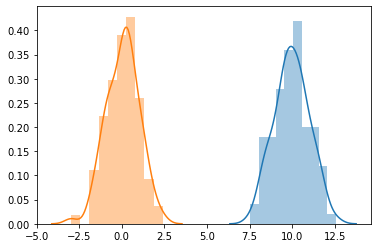

In [36]:
n_samples=100

target = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.]))


p=torch.tensor([1.]).detach().requires_grad_(True)
q=torch.tensor([10.]).detach().requires_grad_(True)
x=torch.randn(n_samples)

sn.distplot((p*x+q).detach())
sn.distplot(target.sample((100,)))


In [37]:
KLs=[]
H_grad=[]
lr=0.05

ps=[]
qs=[]
for _ in range(3000):
    x=torch.randn(n_samples)

    n_samples=x.shape[0]
    sample=p*x+q
    
    K=KL(sample.view(-1,1),target.sample((n_samples,)),k=5,device='cpu')
    
    KLs.append(K.item())
    
    p_grad=torch.autograd.grad(K,p,retain_graph=True)
    q_grad=torch.autograd.grad(K,q,retain_graph=True)

   # print(lp_grad_p[0])
    
    p.data.add_(-lr*p_grad[0])
    q.data.add_(-lr*q_grad[0])
    ps.append(p.item())
    qs.append(q.item())

In [38]:
print(p.item(),q.item())

0.9016228318214417 -0.395984947681427


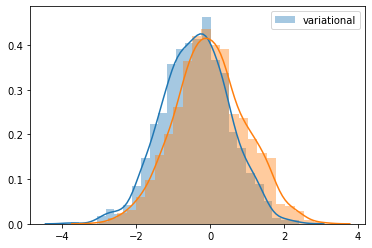

In [39]:
x=torch.randn(1000)
sn.distplot((p*x+q).detach(), label='variational')
sn.distplot(target.sample((1000,)))
plt.legend()

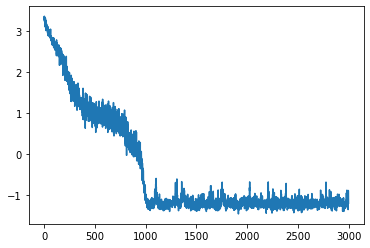

In [40]:
plt.plot(KLs)

Text(0.5, 0, 'scale')

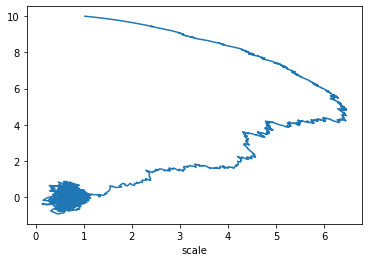

In [41]:
plt.plot(ps,qs)
plt.xlabel('scale')

# consistency #

In [145]:
import timeit
import numpy as np
from tqdm import trange

n_samples=100
target = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.]))
lr=0.1


NN_ps=[]
NN_qs=[]
NN_time=[]
for n in trange(20):
    p=torch.tensor([1.]).uniform_(0.5,5.).detach().requires_grad_(True).to(device)
    q=torch.tensor([10.]).uniform_(0.,10.).detach().requires_grad_(True).to(device)
    start = timeit.default_timer()

    for _ in range(2000):
        x=torch.randn(n_samples).to(device)

        n_samples=x.shape[0]
        sample=p*x+q

        K=KL(sample.view(-1,1),target.sample((n_samples,)).to(device),k=5,device='cpu')

        p_grad=torch.autograd.grad(K,p,retain_graph=True)
        q_grad=torch.autograd.grad(K,q,retain_graph=True)

        p.data.add_(-lr*p_grad[0])
        q.data.add_(-lr*q_grad[0])

    NN_ps.append((p.item()))
    NN_qs.append((q.item()))
    stop = timeit.default_timer()
    NN_time.append(stop - start)
                 

    

100%|██████████| 20/20 [01:34<00:00,  4.70s/it]


average time [s]: 4.685762455058284
mean: (-0.04008566774427891, 0.4569391992067915)
scale: (1.1856259882450104, 0.2521446274233837)


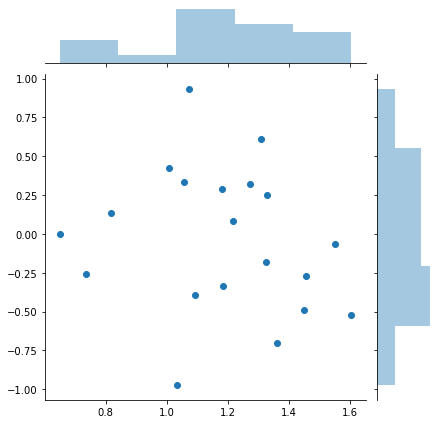

In [146]:
sn.jointplot(NN_ps,NN_qs)
print('average time [s]: '+str(np.mean(NN_time)))
print('mean: '+str((np.mean(NN_qs),np.std(NN_qs))))
print('scale: '+str((np.mean(NN_ps),np.std(NN_ps))))

In [149]:
import timeit
import numpy as np
from tqdm import trange

n_samples=100
target = torch.distributions.Normal(torch.tensor([0.0],device=device), torch.tensor([1.],device=device))
lr=0.1


SSGE_ps=[]
SSGE_qs=[]
SSGE_time=[]
for n in trange(20):
    p=torch.Tensor(1).uniform_(0.5,5.).detach().requires_grad_(True).to(device)
    q=torch.Tensor(1).uniform_(0.,10.).detach().requires_grad_(True).to(device)
    start = timeit.default_timer()

    for _ in range(2000):
        x=torch.randn(n_samples).to(device)

        n_samples=x.shape[0]
        repeat_arg = (n_samples,) + (1,) * len(p.size())
        pr=p.repeat(*repeat_arg)
        qr=q.repeat(*repeat_arg)
        y=pr*x+qr

        sample=y[0].unsqueeze(-1)

        lp=-target.log_prob(sample).mean()
        lp_grad_p=torch.autograd.grad(lp,p,retain_graph=True)
        lp_grad_q=torch.autograd.grad(lp,q,retain_graph=True)


        I=torch.eye(n_samples).to(device)
        Jp = torch.autograd.grad(y, pr,
                              grad_outputs=I,
                              retain_graph=True)
        Jq = torch.autograd.grad(y, qr,
                              grad_outputs=I,
                              retain_graph=True)
        Jp[0].shape
        y_grad=torch.stack([Jp[0],Jq[0]],dim=1).to(device)


        grad_estimator = EntropyGradient(eta=0.1)
        entropy_grad = grad_estimator(sample, y_grad)

        p.data.add_(-lr*(entropy_grad[0]+lp_grad_p[0]))
        q.data.add_(-lr*(entropy_grad[1]+lp_grad_q[0]))

    SSGE_ps.append((p.item()))
    SSGE_qs.append((q.item()))
    stop = timeit.default_timer()
    SSGE_time.append(stop - start)
                 


100%|██████████| 20/20 [11:38<00:00, 34.90s/it]


NN average time [s]: 4.685762455058284
NN mean: (-0.04008566774427891, 0.4569391992067915)
NN scale: (1.1856259882450104, 0.2521446274233837)
SSGE average time [s]: nan
SSGE mean: (nan, nan)
SSGE scale: (nan, nan)


/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


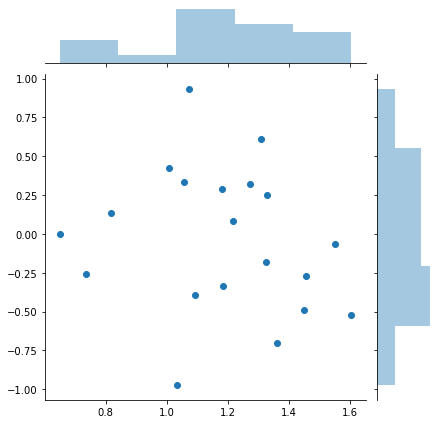

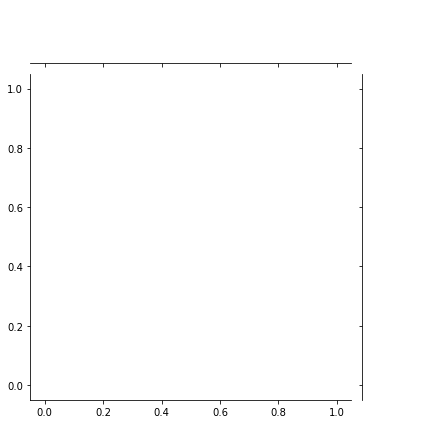

In [148]:
sn.jointplot(NN_ps,NN_qs)
sn.jointplot(SSGE_ps,SSGE_qs)
print('NN average time [s]: '+str(np.mean(NN_time)))
print('NN mean: '+str((np.mean(NN_qs),np.std(NN_qs))))
print('NN scale: '+str((np.mean(NN_ps),np.std(NN_ps))))
print('SSGE average time [s]: '+str(np.mean(SSGE_time)))
print('SSGE mean: '+str((np.mean(SSGE_qs),np.std(SSGE_qs))))
print('SSGE scale: '+str((np.mean(SSGE_ps),np.std(SSGE_ps))))
